In [464]:
import xgboost as xgb
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime
import cvxpy as cvx

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
from scipy import stats
from pandas.tseries.holiday import USFederalHolidayCalendar

In [2]:
data = pd.read_csv('cleaned_data/feature_set1.csv', index_col=[0,1])
data.index = data.index.set_levels(pd.to_datetime(data.index.levels[0]), level=0)

In [3]:
data.head()

perc_holding  mean_weight  median_weight  \
rebalance_date ticker                                             
2001-08-15     GE           0.87500     0.274133       0.240465   
               PFE          0.84375     0.011433       0.009863   
               MSFT         0.81250     0.008682       0.006144   
               INTC         0.81250     0.009413       0.009634   
               JNJ          0.78125     0.015712       0.013860   

                       perc_25_weight  perc_75_weight  last_21d_ret  \
rebalance_date ticker                                                 
2001-08-15     GE            0.183416        0.369918     -0.092388   
               PFE           0.007516        0.012487      0.064541   
               MSFT          0.003021        0.009056     -0.099276   
               INTC          0.004311        0.012153      0.015683   
               JNJ           0.010072        0.020424      0.037880   

                       last_42d_ret  last_63d_ret  future_ret  
rebalance_date ticker                                          
2001-08-15     GE         -0.142150     -0.198015   -0.020835  
               PFE        -0.036594     -0.079561    0.031055  
               MSFT       -0.048956     -0.064633    0.043512  
               INTC        0.097143      0.070836    0.052513  
               JNJ         0.095119      0.146527    0.057328

In [4]:
X = data.drop("future_ret", axis = 1)
Y = data["future_ret"]

train_X = X["2006-01-01":"2018-12-31"]
test_X = X["2019-01-01":]
train_Y = Y["2006-01-01":"2018-12-31"]
test_Y = Y["2019-01-01":]

# Handle outliers

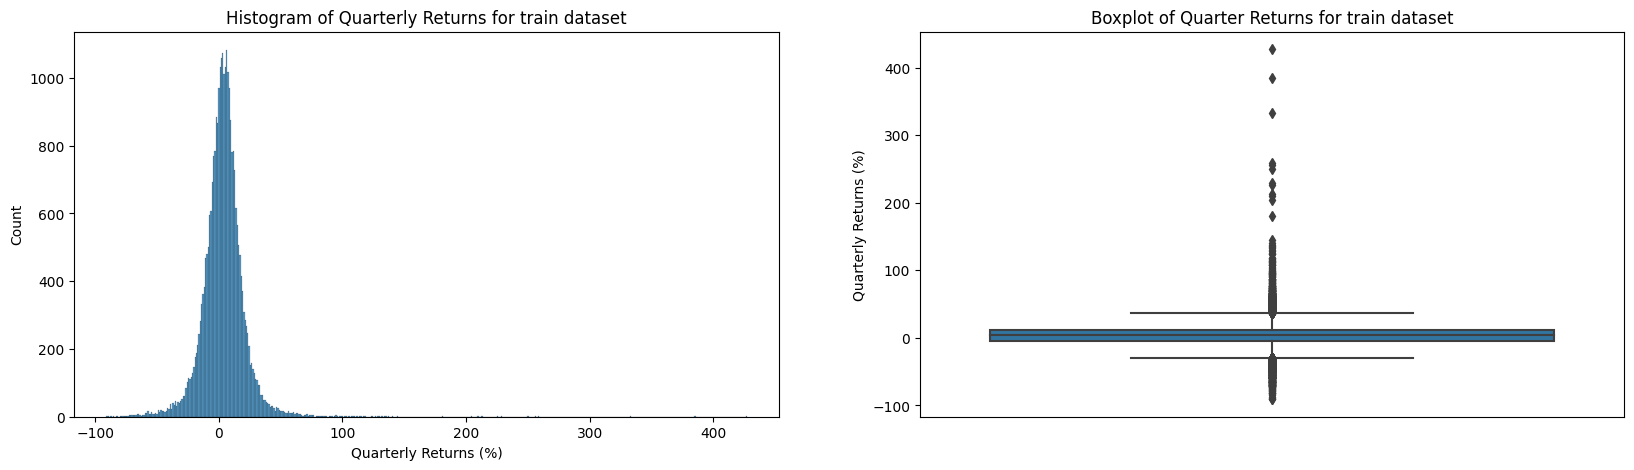

In [5]:
# Many outliers
fig, axs = plt.subplots(1,2, figsize=(20,5))
sns.histplot(train_Y * 100,ax=axs[0])
sns.boxplot(train_Y * 100,ax=axs[1])
axs[0].set_xlabel("Quarterly Returns (%)")
axs[0].set_title("Histogram of Quarterly Returns for train dataset")
axs[1].set_ylabel("Quarterly Returns (%)")
axs[1].set_xticks([])
axs[1].set_title("Boxplot of Quarter Returns for train dataset")
print()

In [6]:
# Cap outliers before log transformation
upper_Y = train_Y.mean() + 3 * train_Y.std()
lower_Y = train_Y.mean() - 3 * train_Y.std()
train_Y = train_Y.clip(lower=lower_Y,upper=upper_Y)

In [7]:
# Perform same transformation for test dataset
test_Y = test_Y.clip(lower=lower_Y,upper=upper_Y)
Y = Y.clip(lower=lower_Y, upper=upper_Y)

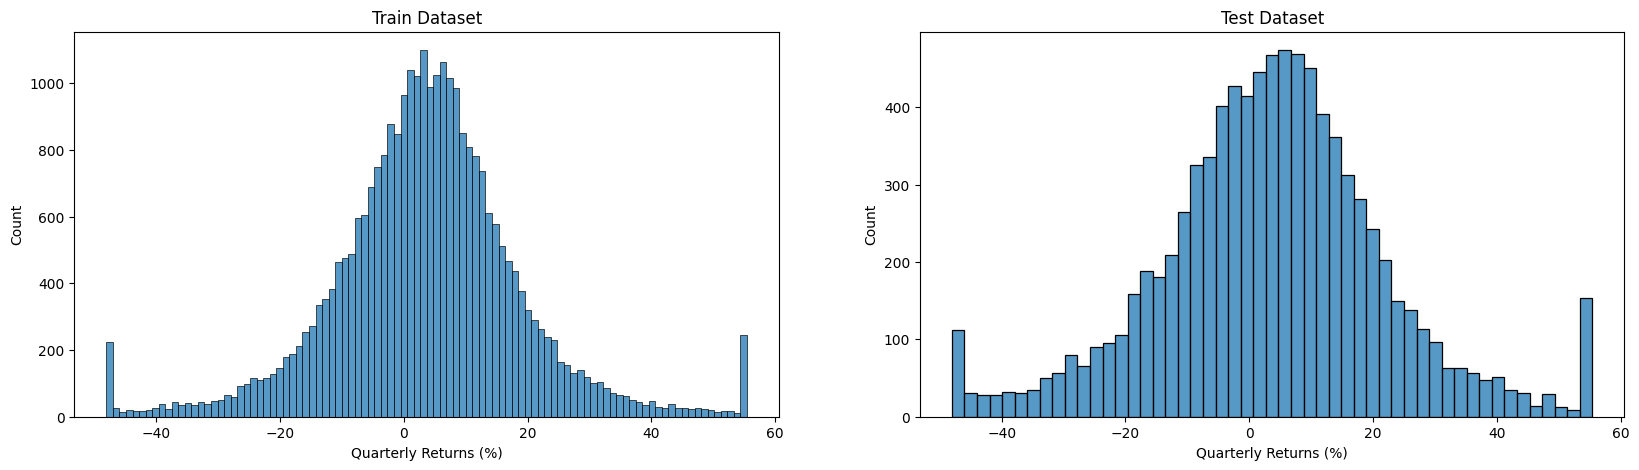

In [8]:
fig, axs = plt.subplots(1,2, figsize=(20,5))
sns.histplot(train_Y * 100, ax=axs[0])
axs[0].set_xlabel("Quarterly Returns (%)")
axs[0].set_title("Train Dataset")
sns.histplot(test_Y * 100, ax=axs[1])
axs[1].set_xlabel("Quarterly Returns (%)")
axs[1].set_title("Test Dataset")
print()

# EDA Features

In [178]:
train_X.describe()

,perc_holding,mean_weight,median_weight,perc_25_weight,perc_75_weight,last_21d_ret,last_42d_ret,last_63d_ret
count,29059.000000,29059.000000,29059.000000,29059.000000,29059.000000,29059.000000,29059.000000,29059.000000
mean,0.118292,0.008990,0.002972,0.001114,0.008805,0.011582,0.020283,0.037898
std,0.134739,0.014800,0.011299,0.007168,0.019246,0.100830,0.149818,0.171332
min,0.000551,-0.000170,-0.000039,-0.000146,-0.000010,-0.727778,-0.841782,-0.899941
25%,0.033223,0.003757,0.000685,0.000181,0.002730,-0.039320,-0.047964,-0.044637
50%,0.067151,0.006356,0.001312,0.000369,0.005360,0.012036,0.022451,0.038291
75%,0.143134,0.010156,0.002627,0.000797,0.009857,0.061366,0.089615,0.118634
max,0.799443,0.716183,0.716183,0.574275,0.858092,1.568628,5.911111,4.098360


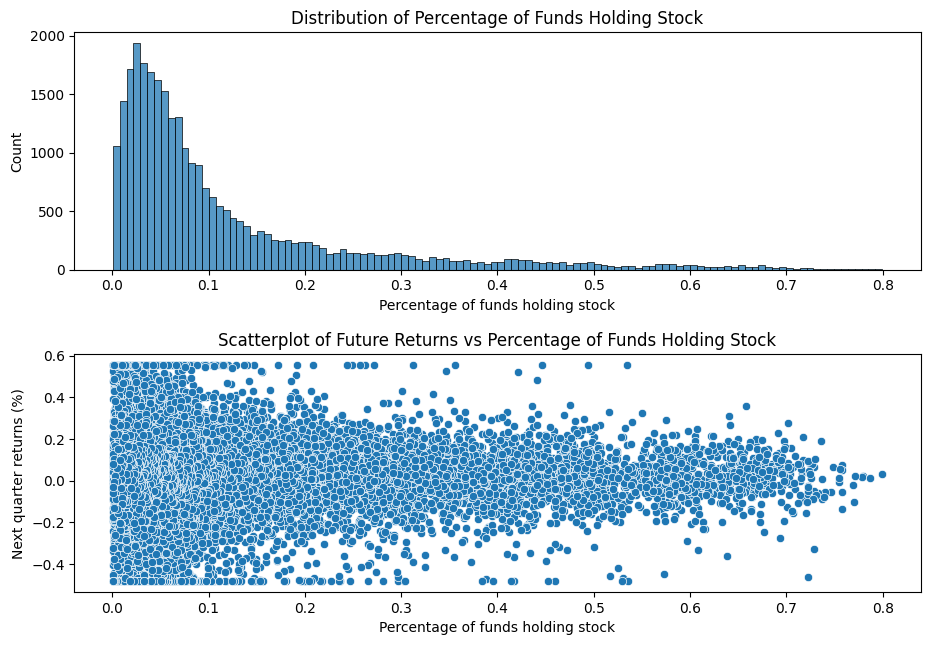

In [890]:
fig, ax = plt.subplots(2,1, figsize=(10,7))
fig.tight_layout(pad=4)

sns.histplot(x="perc_holding", data=train_X, ax=ax[0])
ax[0].set_title("Distribution of Percentage of Funds Holding Stock")
ax[0].set_xlabel("Percentage of funds holding stock")

sns.scatterplot(data=pd.concat([train_X,train_Y],axis=1), x="perc_holding",y="future_ret",ax=ax[1])
ax[1].set_title("Scatterplot of Future Returns vs Percentage of Funds Holding Stock")
ax[1].set_ylabel("Next quarter returns (%)")
ax[1].set_xlabel("Percentage of funds holding stock")
plt.show()

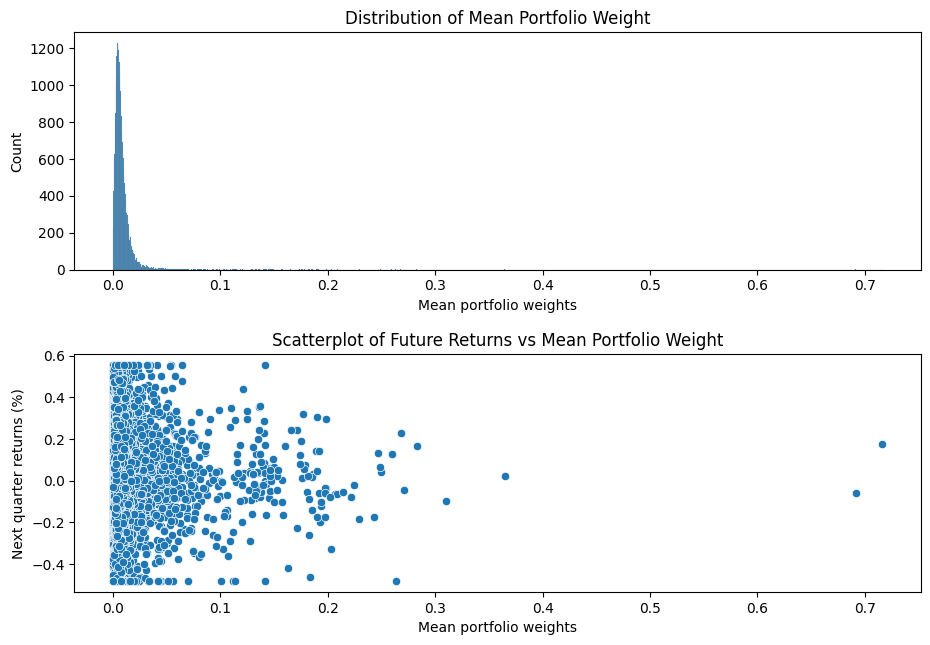

In [892]:
fig, ax = plt.subplots(2,1, figsize=(10,7))
fig.tight_layout(pad=4)

sns.histplot(x="mean_weight", data=train_X, ax=ax[0])
ax[0].set_title("Distribution of Mean Portfolio Weight")
ax[0].set_xlabel("Mean portfolio weights")

sns.scatterplot(data=pd.concat([train_X,train_Y],axis=1), x="mean_weight",y="future_ret",ax=ax[1])
ax[1].set_title("Scatterplot of Future Returns vs Mean Portfolio Weight")
ax[1].set_ylabel("Next quarter returns (%)")
ax[1].set_xlabel("Mean portfolio weights")
plt.show()

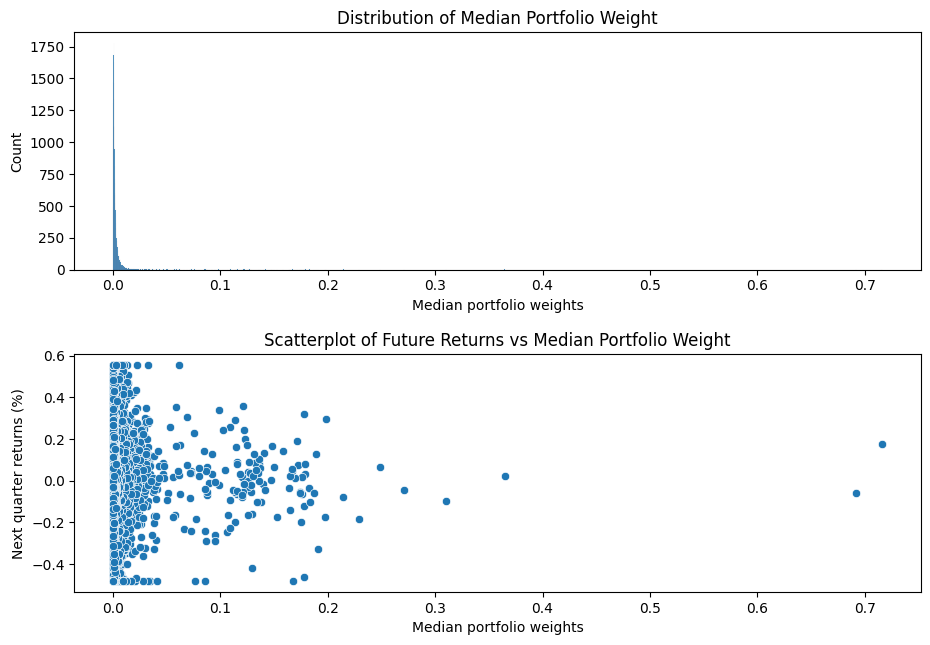

In [893]:
fig, ax = plt.subplots(2,1, figsize=(10,7))
fig.tight_layout(pad=4)

sns.histplot(x="median_weight", data=train_X, ax=ax[0])
ax[0].set_title("Distribution of Median Portfolio Weight")
ax[0].set_xlabel("Median portfolio weights")

sns.scatterplot(data=pd.concat([train_X,train_Y],axis=1), x="median_weight",y="future_ret",ax=ax[1])
ax[1].set_title("Scatterplot of Future Returns vs Median Portfolio Weight")
ax[1].set_ylabel("Next quarter returns (%)")
ax[1].set_xlabel("Median portfolio weights")
plt.show()

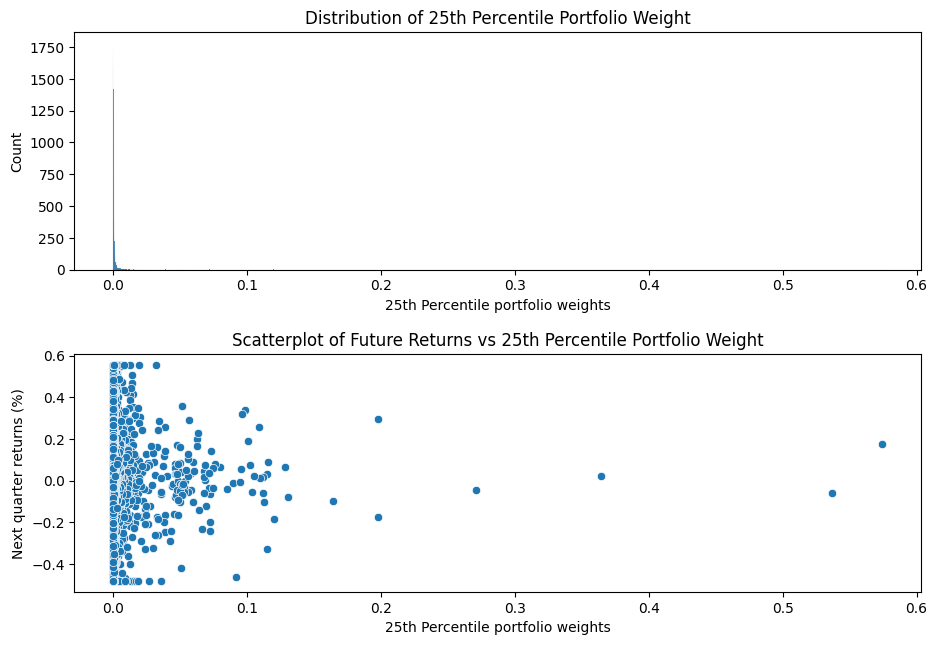

In [894]:
fig, ax = plt.subplots(2,1, figsize=(10,7))
fig.tight_layout(pad=4)

sns.histplot(x="perc_25_weight", data=train_X, ax=ax[0])
ax[0].set_title("Distribution of 25th Percentile Portfolio Weight")
ax[0].set_xlabel("25th Percentile portfolio weights")

sns.scatterplot(data=pd.concat([train_X,train_Y],axis=1), x="perc_25_weight",y="future_ret",ax=ax[1])
ax[1].set_title("Scatterplot of Future Returns vs 25th Percentile Portfolio Weight")
ax[1].set_ylabel("Next quarter returns (%)")
ax[1].set_xlabel("25th Percentile portfolio weights")
plt.show()

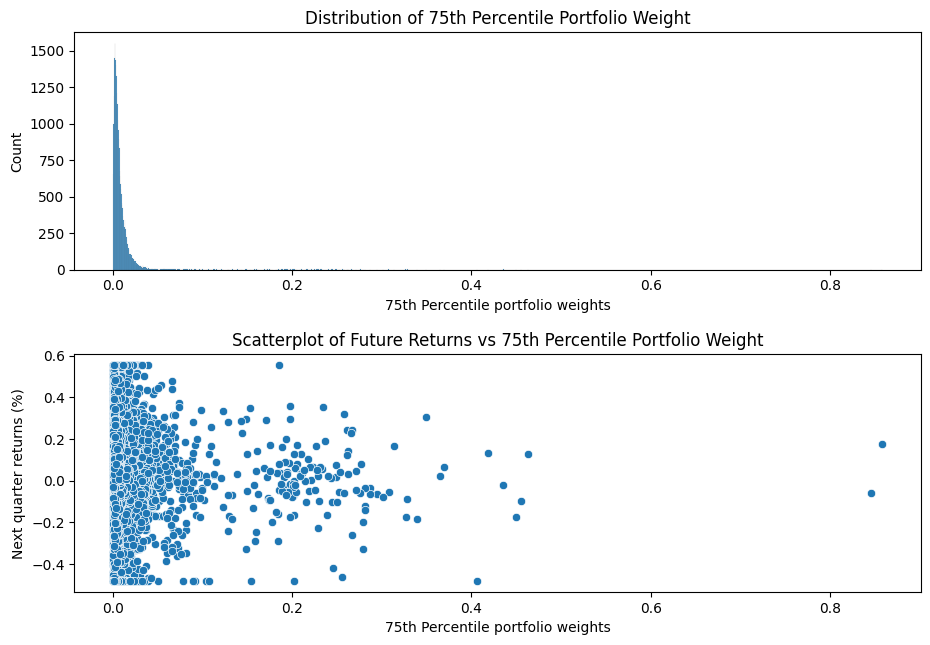

In [895]:
fig, ax = plt.subplots(2,1, figsize=(10,7))
fig.tight_layout(pad=4)

sns.histplot(x="perc_75_weight", data=train_X, ax=ax[0])
ax[0].set_title("Distribution of 75th Percentile Portfolio Weight")
ax[0].set_xlabel("75th Percentile portfolio weights")

sns.scatterplot(data=pd.concat([train_X,train_Y],axis=1), x="perc_75_weight",y="future_ret",ax=ax[1])
ax[1].set_title("Scatterplot of Future Returns vs 75th Percentile Portfolio Weight")
ax[1].set_ylabel("Next quarter returns (%)")
ax[1].set_xlabel("75th Percentile portfolio weights")
plt.show()

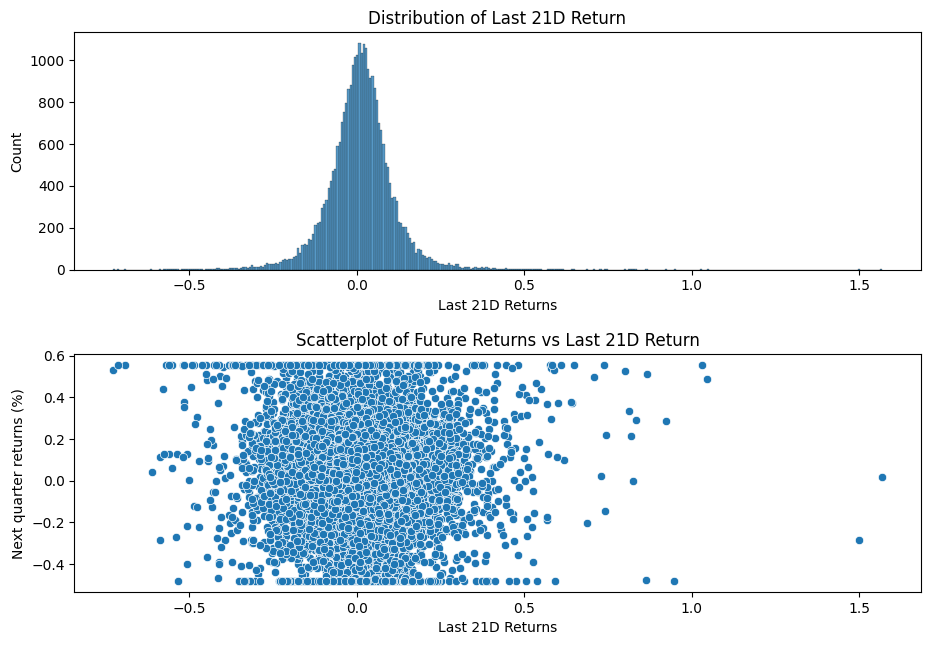

In [896]:
fig, ax = plt.subplots(2,1, figsize=(10,7))
fig.tight_layout(pad=4)

sns.histplot(x="last_21d_ret", data=train_X, ax=ax[0])
ax[0].set_title("Distribution of Last 21D Return")
ax[0].set_xlabel("Last 21D Returns")

sns.scatterplot(data=pd.concat([train_X,train_Y],axis=1), x="last_21d_ret",y="future_ret",ax=ax[1])
ax[1].set_title("Scatterplot of Future Returns vs Last 21D Return")
ax[1].set_ylabel("Next quarter returns (%)")
ax[1].set_xlabel("Last 21D Returns")
plt.show()

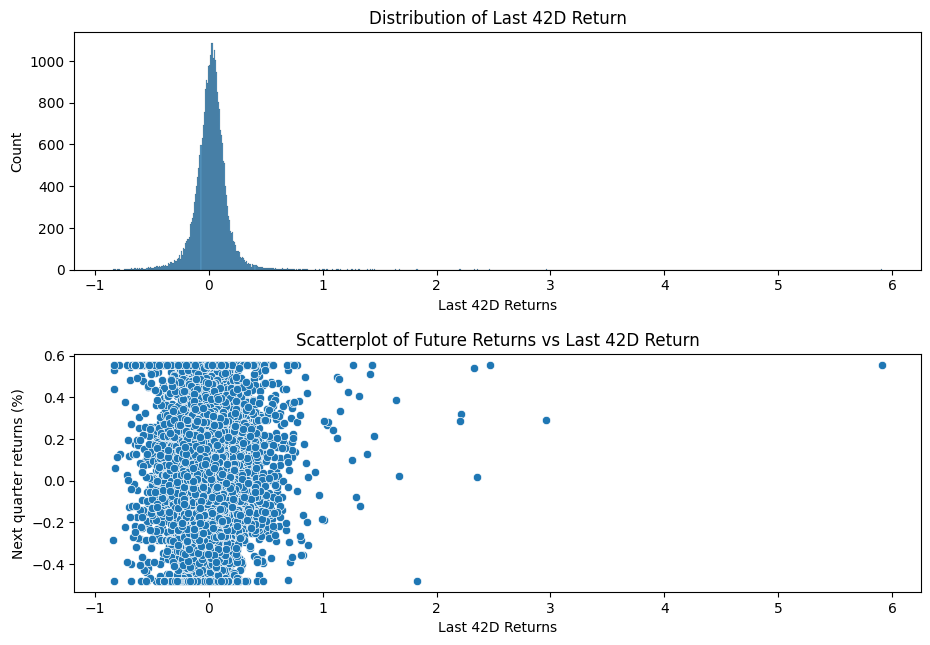

In [897]:
fig, ax = plt.subplots(2,1, figsize=(10,7))
fig.tight_layout(pad=4)

sns.histplot(x="last_42d_ret", data=train_X, ax=ax[0])
ax[0].set_title("Distribution of Last 42D Return")
ax[0].set_xlabel("Last 42D Returns")

sns.scatterplot(data=pd.concat([train_X,train_Y],axis=1), x="last_42d_ret",y="future_ret",ax=ax[1])
ax[1].set_title("Scatterplot of Future Returns vs Last 42D Return")
ax[1].set_ylabel("Next quarter returns (%)")
ax[1].set_xlabel("Last 42D Returns")
plt.show()

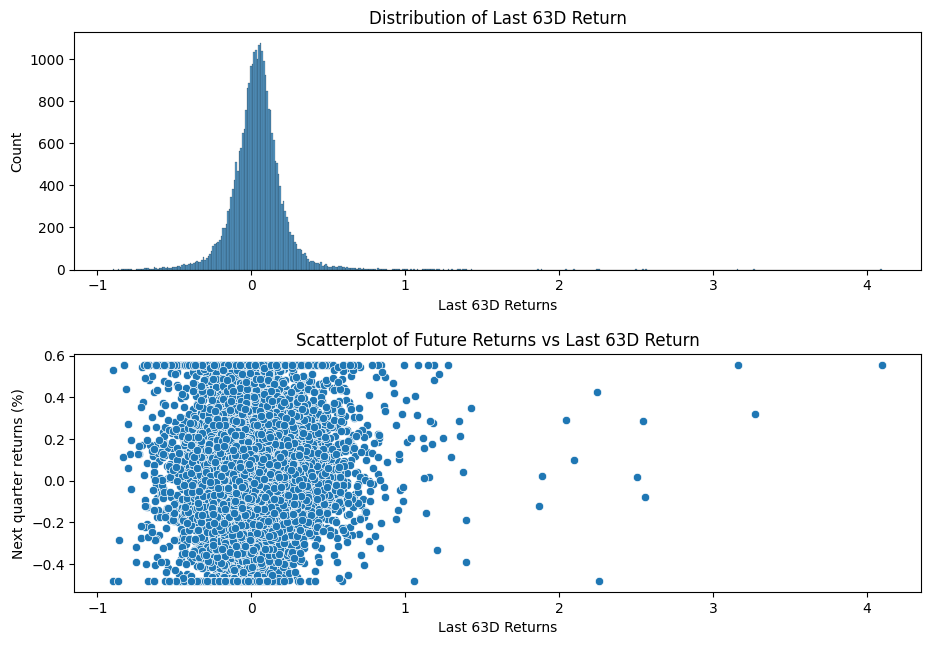

In [898]:
fig, ax = plt.subplots(2,1, figsize=(10,7))
fig.tight_layout(pad=4)

sns.histplot(x="last_63d_ret", data=train_X, ax=ax[0])
ax[0].set_title("Distribution of Last 63D Return")
ax[0].set_xlabel("Last 63D Returns")

sns.scatterplot(data=pd.concat([train_X,train_Y],axis=1), x="last_63d_ret",y="future_ret",ax=ax[1])
ax[1].set_title("Scatterplot of Future Returns vs Last 63D Return")
ax[1].set_ylabel("Next quarter returns (%)")
ax[1].set_xlabel("Last 63D Returns")
plt.show()

<AxesSubplot: >

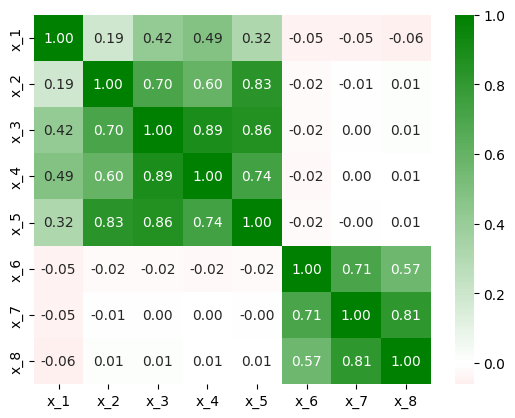

In [279]:
from matplotlib.colors import LinearSegmentedColormap
cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
tmp = train_X.copy()
tmp.columns = ["x_1",
               "x_2",
               "x_3",
               "x_4",
               "x_5",
               "x_6",
               "x_7", 
               "x_8"]
sns.heatmap(tmp.corr(method="spearman"), annot=True, cmap=cmap, center=0, fmt=".2f")

# Baseline model using last 63d (quarter) return as proxy for future return

In [291]:
pred_Y = Y.groupby('ticker').shift(1)
tmp = pd.DataFrame(Y)
tmp["pred"] = pred_Y
tmp = tmp.dropna()

In [292]:
train_tmp = tmp.loc["2006-01-01":"2018-12-31"]
test_tmp = tmp.loc["2019-01-01":]

bl_train_rmse = mean_squared_error(train_tmp.future_ret, train_tmp.pred, squared=False)
bl_test_rmse = mean_squared_error(test_tmp.future_ret, test_tmp.pred, squared=False)

print(f"Train RMSE: {bl_train_rmse}")
print(f"Test RMSE: {bl_test_rmse}")

Train RMSE: 0.21068979681556063
Test RMSE: 0.265868175672819


In [295]:
print(f"Information coefficient (Pearson) of train set: {round(train_tmp.corr().iloc[0,1],4)}")
print(f"Information coefficient (Spearman) of train set: {round(train_tmp.corr(method='spearman').iloc[0,1],4)}")

Information coefficient (Pearson) of train set: 0.0632
Information coefficient (Spearman) of train set: 0.0359


In [297]:
print(f"Information coefficient (Pearson) of test set: {round(test_tmp.corr().iloc[0,1],4)}")
print(f"Information coefficient (Spearman) of test set: {round(test_tmp.corr(method='spearman').iloc[0,1],4)}")

Information coefficient (Pearson) of test set: -0.018
Information coefficient (Spearman) of test set: -0.0118


# Linear Regression

In [307]:
lr_model = sm.OLS(train_Y,sm.add_constant(train_X))
results = lr_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             future_ret   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     40.69
Date:                Tue, 21 Mar 2023   Prob (F-statistic):           3.60e-65
Time:                        17:34:10   Log-Likelihood:                 13323.
No. Observations:               29059   AIC:                        -2.663e+04
Df Residuals:                   29050   BIC:                        -2.655e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0415      0.001     28.943      0.000       0.039       0.044
perc_holding      -0.0524      0.007     -7.414      0.000      -0.066      -0.039
mean_weight       -0.5309      0.168     -3.151      0.002      -0.861      -0.201
median_weight     -0.1021      0.372     -0.274      0.784      -0.832       0.627
perc_25_weight     0.4559      0.397      1.147      0.251      -0.323       1.235
perc_75_weight     0.2189      0.169      1.299      0.194      -0.111       0.549
last_21d_ret      -0.0543      0.013     -4.178      0.000      -0.080      -0.029
last_42d_ret      -0.0993      0.013     -7.594      0.000      -0.125      -0.074
last_63d_ret       0.1456      0.010     14.718      0.000       0.126       0.165
==============================================================================
Omnibus:                     1191.075   Durbin-Watson:                   1.393
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3909.421
Skew:                          -0.009   Prob(JB):                         0.00
Kurtosis:                       4.797   Cond. No.                         605.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [308]:
lr_pred_train_Y = results.predict(sm.add_constant(train_X))
lr_pred_test_Y = results.predict(sm.add_constant(test_X))

In [309]:
lr_train_rmse = mean_squared_error(train_Y, lr_pred_train_Y, squared=False)
lr_test_rmse = mean_squared_error(test_Y, lr_pred_test_Y, squared=False)

print(f"Train RMSE: {lr_train_rmse}")
print(f"Test RMSE: {lr_test_rmse}")

Train RMSE: 0.15298232740406945
Test RMSE: 0.19232447405751235


In [318]:
print(f"Information coefficient (Pearson) of train set: {round(pd.concat([train_Y, lr_pred_train_Y], axis=1).corr().iloc[0,1],4)}")
print(f"Information coefficient (Spearman) of train set: {round(pd.concat([train_Y, lr_pred_train_Y], axis=1).corr(method='spearman').iloc[0,1],4)}")

Information coefficient (Pearson) of train set: 0.1053
Information coefficient (Spearman) of train set: 0.083


In [319]:
print(f"Information coefficient (Pearson) of test set: {round(pd.concat([test_Y, lr_pred_test_Y], axis=1).corr().iloc[0,1],4)}")
print(f"Information coefficient (Spearman) of test set: {round(pd.concat([test_Y, lr_pred_test_Y], axis=1).corr(method='spearman').iloc[0,1],4)}")

Information coefficient (Pearson) of test set: -0.1092
Information coefficient (Spearman) of test set: -0.0635


# XGB

In [65]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', seed=123)
xgb_model.fit(train_X, train_Y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [66]:
xgb_pred_train_Y = xgb_model.predict(train_X)
xgb_pred_test_Y = xgb_model.predict(test_X)

In [67]:
xgb_train_rmse = mean_squared_error(train_Y, xgb_pred_train_Y, squared=False)
xgb_test_rmse = mean_squared_error(test_Y, xgb_pred_test_Y, squared=False)

print(f"Train RMSE: {xgb_train_rmse}")
print(f"Test RMSE: {xgb_test_rmse}")

Train RMSE: 0.12176417945365192
Test RMSE: 0.1921488186533799


In [68]:
print(f"Information coefficient (Pearson) of train set: {round(pd.DataFrame(train_Y).assign(pred=xgb_pred_train_Y).corr().iloc[0,1],4)}")
print(f"Information coefficient (Spearman) of train set: {round(pd.DataFrame(train_Y).assign(pred=xgb_pred_train_Y).corr(method='spearman').iloc[0,1],4)}")

Information coefficient (Pearson) of train set: 0.6555
Information coefficient (Spearman) of train set: 0.5145


In [69]:
print(f"Information coefficient (Pearson) of test set: {round(pd.DataFrame(test_Y).assign(pred=xgb_pred_test_Y).corr().iloc[0,1],4)}")
print(f"Information coefficient (Spearman) of test set: {round(pd.DataFrame(test_Y).assign(pred=xgb_pred_test_Y).corr(method='spearman').iloc[0,1],4)}")

Information coefficient (Pearson) of test set: 0.092
Information coefficient (Spearman) of test set: 0.048


# XGB - Hyperparameter Tuning + Cross validation

In [96]:
# For bayesian optimisation hyperparameter tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [310]:
def get_xgb_best_param(train_X, train_Y):
    curr_best_rounds = 0
    # Search range
    xgb_parameters = {
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'max_depth': hp.quniform("max_depth", 3, 10, 1),
        "eta": hp.uniform("eta", 0.1, 0.5),
        'gamma': hp.uniform ('gamma', 0,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        "subsample": hp.uniform("subsample", 0.5, 1),
        'reg_alpha' : hp.choice('reg_alpha', [0.001, 0.01, 0.1, 1, 10, 100]),
    }

    def xgb_objective_func(space):
        params = {
            'colsample_bytree':space["colsample_bytree"],
            'max_depth':int(space["max_depth"]),
            'eta':space["eta"],
            'gamma':space["gamma"],
            'min_child_weight':int(space["min_child_weight"]),
            'subsample':space["subsample"],
            'reg_alpha':space["reg_alpha"],
            'objective':'reg:squarederror'
        }
        
        
        # Set num boost rounds to a high number and rely on early stopping round
        xgb_cv = xgb.cv(dtrain=xgb.DMatrix(train_X,train_Y), 
                        params=params, 
                        folds=KFold(3, shuffle=True),
                        num_boost_round=500, 
                        early_stopping_rounds=10, 
                        metrics="rmse", 
                        as_pandas=True, 
                        seed=123)
        min_rmse = xgb_cv['test-rmse-mean'].min()
        nonlocal curr_best_rounds
        curr_best_rounds = xgb_cv['test-rmse-mean'].argmin()
        return {'loss': min_rmse, 'status': STATUS_OK}

    trials = Trials()

    xgb_best_param = fmin(fn = xgb_objective_func,
                      space = xgb_parameters,
                      algo = tpe.suggest,
                      max_evals = 100,
                      trials = trials)      
    xgb_best_param["n_estimators"] = curr_best_rounds
    
    return xgb_best_param

In [311]:
xgb_best_param = get_xgb_best_param(train_X,train_Y)

100%|██████████| 100/100 [02:32<00:00,  1.53s/trial, best loss: 0.15217730126461704]


In [312]:
xgb_best_param

{'colsample_bytree': 0.5384222784911428,
 'eta': 0.15409488726721196,
 'gamma': 0.30711761782719915,
 'max_depth': 6.0,
 'min_child_weight': 6.0,
 'reg_alpha': 1,
 'subsample': 0.9489564436866997,
 'n_estimators': 35}

In [313]:
tuned_xgb_model = xgb.XGBRegressor(
                      colsample_bytree = xgb_best_param["colsample_bytree"], 
                      max_depth=int(xgb_best_param["max_depth"]),
                      eta=xgb_best_param["eta"],
                      gamma=xgb_best_param["gamma"],
                      min_child_weight=int(xgb_best_param["min_child_weight"]),
                      subsample=xgb_best_param["subsample"],
                      reg_alpha=xgb_best_param["reg_alpha"],
                      verbosity=1,
                      eval_metric="rmse",
                      n_estimators=xgb_best_param["n_estimators"],
                      seed=123)
tuned_xgb_model.fit(train_X, train_Y)    

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5384222784911428, early_stopping_rounds=None,
             enable_categorical=False, eta=0.15409488726721196,
             eval_metric='rmse', feature_types=None, gamma=0.30711761782719915,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=6, missing=nan, monotone_constraints=None,
             n_estimators=35, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [314]:
tuned_xgb_pred_train_Y = tuned_xgb_model.predict(train_X)
tuned_xgb_pred_test_Y = tuned_xgb_model.predict(test_X)

In [315]:
tuned_xgb_train_rmse = mean_squared_error(train_Y, tuned_xgb_pred_train_Y, squared=False)
tuned_xgb_test_rmse = mean_squared_error(test_Y, tuned_xgb_pred_test_Y, squared=False)

print(f"Train RMSE: {tuned_xgb_train_rmse}")
print(f"Test RMSE: {tuned_xgb_test_rmse}")

Train RMSE: 0.14970143431806643
Test RMSE: 0.18636662610137467


In [316]:
print(f"Information coefficient (Pearson) of train set: {round(pd.DataFrame(train_Y).assign(pred=tuned_xgb_pred_train_Y).corr().iloc[0,1],4)}")
print(f"Information coefficient (Spearman) of train set: {round(pd.DataFrame(train_Y).assign(pred=tuned_xgb_pred_train_Y).corr(method='spearman').iloc[0,1],4)}")

Information coefficient (Pearson) of train set: 0.2609
Information coefficient (Spearman) of train set: 0.1734


In [903]:
pd.DataFrame(test_Y).assign(pred=tuned_xgb_pred_test_Y).groupby('rebalance_date').corr(method='spearman')

future_ret      pred
rebalance_date                                 
2019-02-15     future_ret    1.000000  0.081687
               pred          0.081687  1.000000
2019-05-16     future_ret    1.000000 -0.040473
               pred         -0.040473  1.000000
2019-08-15     future_ret    1.000000 -0.127701
               pred         -0.127701  1.000000
2019-11-15     future_ret    1.000000 -0.172212
               pred         -0.172212  1.000000
2020-02-15     future_ret    1.000000  0.054503
               pred          0.054503  1.000000
2020-05-16     future_ret    1.000000  0.134225
               pred          0.134225  1.000000
2020-08-15     future_ret    1.000000  0.134656
               pred          0.134656  1.000000
2020-11-17     future_ret    1.000000  0.262964
               pred          0.262964  1.000000
2021-02-17     future_ret    1.000000  0.001914
               pred          0.001914  1.000000
2021-05-18     future_ret    1.000000 -0.348281
               pred         -0.348281  1.000000
2021-08-17     future_ret    1.000000  0.043383
               pred          0.043383  1.000000
2021-11-16     future_ret    1.000000 -0.124184
               pred         -0.124184  1.000000
2022-02-15     future_ret    1.000000  0.188487
               pred          0.188487  1.000000
2022-05-17     future_ret    1.000000 -0.059468
               pred         -0.059468  1.000000

In [317]:
print(f"Information coefficient (Pearson) of test set: {round(pd.DataFrame(test_Y).assign(pred=tuned_xgb_pred_test_Y).corr().iloc[0,1],4)}")
print(f"Information coefficient (Spearman) of test set: {round(pd.DataFrame(test_Y).assign(pred=tuned_xgb_pred_test_Y).corr(method='spearman').iloc[0,1],4)}")

Information coefficient (Pearson) of test set: 0.0954
Information coefficient (Spearman) of test set: 0.0648


# LightGBM

In [50]:
lgb_model = lgb.LGBMRegressor(seed=123)
lgb_model.fit(train_X, train_Y)

LGBMRegressor(seed=123)

In [51]:
lgb_pred_train_Y = lgb_model.predict(train_X)
lgb_pred_test_Y = lgb_model.predict(test_X)

In [52]:
lgb_train_rmse = mean_squared_error(train_Y, lgb_pred_train_Y, squared=False)
lgb_test_rmse = mean_squared_error(test_Y, lgb_pred_test_Y, squared=False)

print(f"Train RMSE: {lgb_train_rmse}")
print(f"Test RMSE: {lgb_test_rmse}")

Train RMSE: 0.1391749125061907
Test RMSE: 0.18764409582960948


In [53]:
print(f"Information coefficient (Pearson) of train set: {round(pd.DataFrame(train_Y).assign(pred=lgb_pred_train_Y).corr().iloc[0,1],4)}")
print(f"Information coefficient (Spearman) of train set: {round(pd.DataFrame(train_Y).assign(pred=lgb_pred_train_Y).corr(method='spearman').iloc[0,1],4)}")

Information coefficient (Pearson) of train set: 0.4971
Information coefficient (Spearman) of train set: 0.3646


In [54]:
print(f"Information coefficient (Pearson) of test set: {round(pd.DataFrame(test_Y).assign(pred=lgb_pred_test_Y).corr().iloc[0,1],4)}")
print(f"Information coefficient (Spearman) of test set: {round(pd.DataFrame(test_Y).assign(pred=lgb_pred_test_Y).corr(method='spearman').iloc[0,1],4)}")

Information coefficient (Pearson) of test set: 0.1019
Information coefficient (Spearman) of test set: 0.0737


<AxesSubplot: xlabel='rebalance_date'>

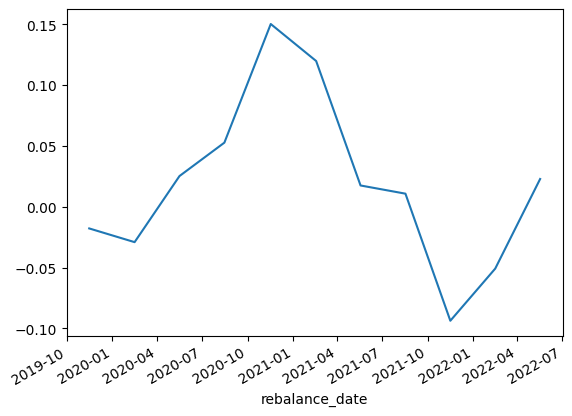

In [350]:
pd.DataFrame(test_Y).assign(pred=tuned_xgb_pred_test_Y).groupby("rebalance_date").apply(lambda x:x.corr().iloc[0,1]).rolling(4).mean().plot()

# LightGBM - Hyperparameter Tuning + Cross validation

In [286]:
def get_lgb_best_param(train_X, train_Y):
    curr_best_rounds = 0
    # Search range
    lgb_parameters = {
        'num_leaves': hp.quniform('num_leaves', 8, 128,2),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        "learning_rate": hp.uniform("learning_rate", 0.1, 0.5),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        "subsample": hp.uniform("subsample", 0.5, 1),
        'min_child_samples': hp.quniform("min_child_samples", 0, 100, 10),
    }

    def lgb_objective_func(space):
        params = {
            'num_leaves': int(space['num_leaves']),
            'colsample_bytree':space["colsample_bytree"],
            'learning_rate':space["learning_rate"],
            'min_child_weight':int(space["min_child_weight"]),
            'subsample':space["subsample"],
            'min_child_samples':int(space['min_child_samples']),
            'objective':'regression',
            'verbose':-1
        }
        
        
        # Set num boost rounds to a high number and rely on early stopping round
        lgb_cv = lgb.cv(train_set=lgb.Dataset(train_X,train_Y), 
                        params=params, 
                        folds=KFold(3, shuffle=True),
                        num_boost_round=500, 
                        early_stopping_rounds=30, 
                        metrics="rmse", 
                        stratified=False,
                        seed=123)
        min_rmse = np.array(lgb_cv['rmse-mean']).min()
        nonlocal curr_best_rounds
        curr_best_rounds = np.array(lgb_cv['rmse-mean']).argmin()
        return {'loss': min_rmse, 'status': STATUS_OK}

    trials = Trials()

    lgb_best_param = fmin(fn = lgb_objective_func,
                      space = lgb_parameters,
                      algo = tpe.suggest,
                      max_evals = 100,
                      trials = trials)      
    lgb_best_param["n_estimators"] = curr_best_rounds
    
    return lgb_best_param

In [287]:
lgb_best_param = get_lgb_best_param(train_X,train_Y)

  1%|          | 1/100 [00:00<00:16,  5.97trial/s, best loss: 0.15297056668648812]

C:\Users\ohste\anaconda3\envs\fyp\lib\site-packages\lightgbm\engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



100%|██████████| 100/100 [00:23<00:00,  4.18trial/s, best loss: 0.15241954738085098]


In [288]:
lgb_best_param

{'colsample_bytree': 0.5554702102487763,
 'learning_rate': 0.1399443752289063,
 'min_child_samples': 60.0,
 'min_child_weight': 9.0,
 'num_leaves': 14.0,
 'subsample': 0.8991825729031796,
 'n_estimators': 20}

In [289]:
tuned_lgb_model = lgb.LGBMRegressor(
                      colsample_bytree = lgb_best_param["colsample_bytree"], 
                      learning_rate=lgb_best_param["learning_rate"],
                      min_child_weight=int(xgb_best_param["min_child_weight"]),
                      num_leaves=int(lgb_best_param["num_leaves"]),
                      subsample=lgb_best_param["subsample"],
                      min_child_samples=int(lgb_best_param["min_child_samples"]),
                      verbosity=1,
                      n_estimators=100,
                      seed=123)
tuned_lgb_model.fit(train_X, train_Y)    

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 29059, number of used features: 8
[LightGBM] [Info] Start training from score 0.035548


LGBMRegressor(colsample_bytree=0.5554702102487763,
              learning_rate=0.1399443752289063, min_child_samples=60,
              min_child_weight=2, num_leaves=14, seed=123,
              subsample=0.8991825729031796, verbosity=1)

In [290]:
tuned_lgb_pred_train_Y = tuned_lgb_model.predict(train_X)
tuned_lgb_pred_test_Y = tuned_lgb_model.predict(test_X)

In [291]:
tuned_lgb_train_rmse = mean_squared_error(train_Y, tuned_lgb_pred_train_Y, squared=False)
tuned_lgb_test_rmse = mean_squared_error(test_Y, tuned_lgb_pred_test_Y, squared=False)

print(f"Train RMSE: {tuned_lgb_train_rmse}")
print(f"Test RMSE: {tuned_lgb_test_rmse}")

Train RMSE: 0.1460203063502582
Test RMSE: 0.18774990431751637


In [292]:
print(f"Information coefficient (Pearson) of train set: {round(pd.DataFrame(train_Y).assign(pred=tuned_lgb_pred_train_Y).corr().iloc[0,1],4)}")
print(f"Information coefficient (Spearman) of train set: {round(pd.DataFrame(train_Y).assign(pred=tuned_lgb_pred_train_Y).corr(method='spearman').iloc[0,1],4)}")

Information coefficient (Pearson) of train set: 0.3552
Information coefficient (Spearman) of train set: 0.2659


In [293]:
print(f"Information coefficient (Pearson) of test set: {round(pd.DataFrame(test_Y).assign(pred=tuned_lgb_pred_test_Y).corr().iloc[0,1],4)}")
print(f"Information coefficient (Spearman) of test set: {round(pd.DataFrame(test_Y).assign(pred=tuned_lgb_pred_test_Y).corr(method='spearman').iloc[0,1],4)}")

Information coefficient (Pearson) of test set: 0.0647
Information coefficient (Spearman) of test set: 0.0542


In [328]:
pd.DataFrame(test_Y).assign(pred=tuned_lgb_pred_test_Y).groupby('rebalance_date').apply(lambda x:x.corr(method='spearman').iloc[0,1])

rebalance_date
2019-02-15    0.112174
2019-05-16    0.025823
2019-08-15   -0.144702
2019-11-15   -0.103353
2020-02-15    0.032843
2020-05-16    0.124735
2020-08-15    0.103759
2020-11-17    0.186842
2021-02-17    0.055202
2021-05-18   -0.328480
2021-08-17    0.024453
2021-11-16   -0.063480
2022-02-15    0.147218
2022-05-17    0.022234
dtype: float64

# Simple Portfolio 

In [491]:
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2000-01-01', end='2022-12-31').to_pydatetime()

# If deadline falls on Sat, Sun or Holiday, move to next business day
def get_filing_deadline(quarter_end):
    curr_deadline = quarter_end + datetime.timedelta(days=45)
    while curr_deadline.weekday() >= 5 or curr_deadline in holidays:
        curr_deadline = curr_deadline + datetime.timedelta(days=1)
    return curr_deadline

In [492]:
close_data = pd.read_csv('raw_data/close_data.csv', index_col=0)
close_data.index = pd.to_datetime(close_data.index)

In [433]:
# Used tuned XGB model
train_y_df = pd.DataFrame(train_Y)
test_y_df = pd.DataFrame(test_Y)
train_y_df["pred"] = tuned_xgb_pred_train_Y
test_y_df["pred"] = tuned_xgb_pred_test_Y

pred_df = pd.concat([train_y_df,test_y_df])

In [441]:
def get_portfolio_return(df, nlargest=200):
    rebalance_date = df.index[0][0]
    top_tickers = df.pred.nlargest(nlargest).index.get_level_values(1)
    next_deadline = get_filing_deadline(rebalance_date + pd.tseries.offsets.QuarterEnd())
    return close_data.pct_change().loc[rebalance_date:next_deadline,top_tickers].mean(axis=1)

def get_portfolio_return2(df, nlargest=200):
    rebalance_date = df.index[0][0]
    top_tickers = df[df.pred > df.pred.nlargest(nlargest).min()].pred
    # Covert to weights of portfolio
    pos_tickers = top_tickers / top_tickers.sum()
    
    next_deadline = get_filing_deadline(rebalance_date + pd.tseries.offsets.QuarterEnd())
    rets = close_data.pct_change().loc[rebalance_date:next_deadline,pos_tickers.index.get_level_values(1)]
    return (pos_tickers * rets).sum(axis=1)

def get_benchmark_return(df):
    rebalance_date = df.index[0][0]
    all_tickers = df.pred.index.get_level_values(1)
    next_deadline = get_filing_deadline(rebalance_date + pd.tseries.offsets.QuarterEnd())
    return close_data.pct_change().loc[rebalance_date:next_deadline,all_tickers].mean(axis=1)

In [435]:
# Take top 200 stocks and equally weigh them
pf1_rets = pred_df.groupby('rebalance_date').apply(get_portfolio_return).reset_index(level=0,drop=True)

# Take top 200 stocks and weigh by magnitude of return
pf2_rets = pred_df.groupby('rebalance_date').apply(get_portfolio_return2).reset_index(level=0,drop=True)

In [436]:
# Returns for just holding SPY (benchmark)
spy_rets = close_data["SPY"].pct_change()

# Returns for just holding equal weight of stock universe
bench_rets = pred_df.groupby('rebalance_date').apply(get_benchmark_return).reset_index(level=0,drop=True)

In [722]:
def get_portfolio_statistics(pf, start_date, end_date, label, exclude_date_range=()):
    filtered_pf = pf.loc[start_date:end_date]
    if exclude_date_range:
        filtered_pf = filtered_pf.loc[~filtered_pf.index.isin(pd.date_range(start=exclude_date_range[0], end=exclude_date_range[1]))]
    pf_ann_ret = np.prod(1+filtered_pf)**(252/len(filtered_pf)) - 1
    pf_ann_vol = filtered_pf.std() * np.sqrt(252)
    print(label)
    print("----------------------------------------------------")
    print(f"Annualized returns of portfolio: {round(pf_ann_ret * 100,2)}%")
    print(f"Annualized volatility of test portfolio: {round(pf_ann_vol * 100,2)}%")
    print(f"Return-Risk Ratio of test portfolio: {round(pf_ann_ret/pf_ann_vol,4)}")
    print(f"Parametric Method - 5% VaR: {min(0,round((pf_ann_ret - 1.64 * pf_ann_vol) * 100,2))}%")
    print("")
    
def plot_portfolio_ts(start_date, end_date):
    pfs = pd.DataFrame({"SPY": spy_rets, "Stock-Universe": bench_rets, "Equally-Weighted Alpha": pf1_rets, "Alpha-Weighted Alpha": pf2_rets})
    pfs = pfs.loc[start_date:end_date]
    cumrets = ((1+pfs).cumprod() - 1) * 100
    plt.figure(figsize=(20,10))
    sns.lineplot(cumrets)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Cumulative Portfolio Returns (%)", fontsize=14)
    plt.title("Cumulative Portfolio Returns across test date range", fontsize=16)
    plt.legend(loc = "upper left", fontsize=14)

In [438]:
get_portfolio_statistics(pf1_rets, "2019-02-15", "2022-08-15","Portfolio 1 statistics for test date range")
get_portfolio_statistics(pf2_rets, "2019-02-15", "2022-08-15","Portfolio 2 statistics for test date range")
get_portfolio_statistics(spy_rets, "2019-02-15", "2022-08-15","SPY portfolio statistics for test date range")
get_portfolio_statistics(bench_rets, "2019-02-15", "2022-08-15","Benchmark portfolio statistics for test date range")

Portfolio 1 statistics for test date range
----------------------------------------------------
Annualized returns of portfolio: 24.63%
Annualized volatility of test portfolio: 30.63%
Return-Risk Ratio of test portfolio: 0.8041
Parametric Method - 5% VaR: -25.6%

Portfolio 2 statistics for test date range
----------------------------------------------------
Annualized returns of portfolio: 27.54%
Annualized volatility of test portfolio: 31.95%
Return-Risk Ratio of test portfolio: 0.8619
Parametric Method - 5% VaR: -24.86%

SPY portfolio statistics for test date range
----------------------------------------------------
Annualized returns of portfolio: 15.06%
Annualized volatility of test portfolio: 22.5%
Return-Risk Ratio of test portfolio: 0.6693
Parametric Method - 5% VaR: -21.84%

Benchmark portfolio statistics for test date range
----------------------------------------------------
Annualized returns of portfolio: 18.06%
Annualized volatility of test portfolio: 26.21%
Return-Risk R

In [448]:
# Vary number of assets in portfolio
get_portfolio_statistics(pred_df.groupby('rebalance_date').apply(lambda x: get_portfolio_return2(x,50)).reset_index(level=0,drop=True), "2019-02-15", "2022-08-15","Portfolio 2 statistics for test date range")
get_portfolio_statistics(pred_df.groupby('rebalance_date').apply(lambda x: get_portfolio_return2(x,100)).reset_index(level=0,drop=True), "2019-02-15", "2022-08-15","Portfolio 2 statistics for test date range")
get_portfolio_statistics(pred_df.groupby('rebalance_date').apply(lambda x: get_portfolio_return2(x,500)).reset_index(level=0,drop=True), "2019-02-15", "2022-08-15","Portfolio 2 statistics for test date range")

Portfolio 2 statistics for test date range
----------------------------------------------------
Annualized returns of portfolio: 31.86%
Annualized volatility of test portfolio: 37.41%
Return-Risk Ratio of test portfolio: 0.8515
Parametric Method - 5% VaR: -29.5%

Portfolio 2 statistics for test date range
----------------------------------------------------
Annualized returns of portfolio: 29.69%
Annualized volatility of test portfolio: 34.7%
Return-Risk Ratio of test portfolio: 0.8556
Parametric Method - 5% VaR: -27.22%

Portfolio 2 statistics for test date range
----------------------------------------------------
Annualized returns of portfolio: 22.59%
Annualized volatility of test portfolio: 28.43%
Return-Risk Ratio of test portfolio: 0.7945
Parametric Method - 5% VaR: -24.04%



# Mean-Variance Optimization

In [788]:
def get_optimized_portfolio_weights(past_returns, 
                                    expected_returns, 
                                    risk_scale = .5, 
                                    max_holding = 0.05):
    # Stock universe
    past_returns = past_returns[expected_returns.index]
    # Filter any stocks away with NA past returns
    past_returns = past_returns.dropna(axis=1)
    expected_returns = expected_returns[expected_returns.index.isin(past_returns.columns)]
    
    # Filter for top 200 stocks based on expected returns
#     expected_returns = expected_returns.nlargest(nlargest)
#     past_returns = past_returns[expected_returns.index]
    
    past_returns = past_returns.T.to_numpy()
    m = past_returns.shape[0]
    cov = np.cov(past_returns)
    x = cvx.Variable(m)
    
    # portfolio variance, in quadratic form
    portfolio_variance = cvx.quad_form(x, cvx.atoms.affine.wraps.psd_wrap(cov))
    portfolio_return = sum(cvx.multiply(expected_returns.to_numpy(), x))
    
    # Objective Function
    objective = cvx.Maximize(portfolio_return - risk_scale * portfolio_variance)

    # Constraints
    # long only, sum of weights equal to 1, no allocation to a single stock great than max_holding of portfolio
    constraints = [x >= 0, sum(x) == 1, x <= max_holding]

    # use cvxpy to solve the objective
    problem = cvx.Problem(objective, constraints)
    # retrieve the weights of the optimized portfolio
    result = problem.solve()
    
    return pd.Series(x.value, index=expected_returns.index)

In [829]:
def get_portfolio_return_optimized(df,
                                   num_lookback = 1000,
                                   risk_scale = 0.5,
                                   max_holding = 0.05):
    rebalance_date = df.index[0][0]
    next_deadline = get_filing_deadline(rebalance_date + pd.tseries.offsets.QuarterEnd())
    # End at day before rebalance date
    past_returns = close_data[:rebalance_date - pd.tseries.offsets.Day()][-num_lookback:]
    weights = get_optimized_portfolio_weights(past_returns, df.pred.reset_index(level=0,drop=True), risk_scale, max_holding)
    rets = close_data.pct_change().loc[rebalance_date:next_deadline,weights.index]
    return (weights * rets).sum(axis=1)
    

In [830]:
opt_pf1_rets = pred_df.groupby('rebalance_date').apply(get_portfolio_return_optimized).reset_index(level=0,drop=True)

In [831]:
get_portfolio_statistics(opt_pf1_rets, "2019-02-15", "2022-08-15","Optimal Portfolio 1 statistics for test date range")

Optimal Portfolio 1 statistics for test date range
----------------------------------------------------
Annualized returns of portfolio: 29.99%
Annualized volatility of test portfolio: 29.82%
Return-Risk Ratio of test portfolio: 1.0058
Parametric Method - 5% VaR: -18.91%



In [837]:
# Vary risk aversion coefficient
rets =[]
vols = []

for i in [0.1, 0.25, 0.5, 0.75, 1]:
    pf = pred_df.groupby('rebalance_date').apply(lambda x:get_portfolio_return_optimized(x, risk_scale=i)).reset_index(level=0,drop=True)
    filtered_pf = pf.loc["2019-02-15":"2022-08-15"]
    pf_ann_ret = np.prod(1+filtered_pf)**(252/len(filtered_pf)) - 1
    pf_ann_vol = filtered_pf.std() * np.sqrt(252)
    rets.append(pf_ann_ret)
    vols.append(pf_ann_vol)

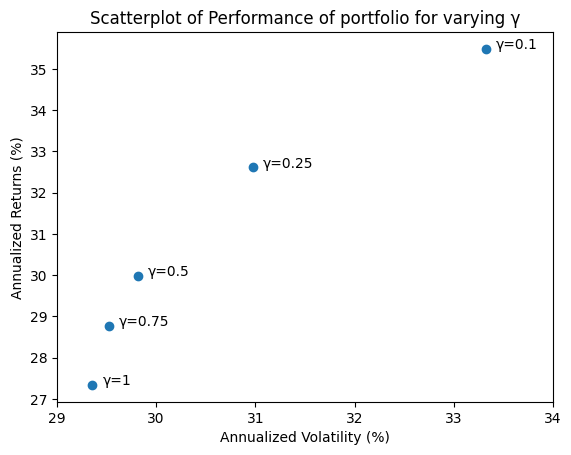

In [868]:
plt.scatter(y=np.array(rets) * 100, x=np.array(vols) * 100)
plt.xlabel("Annualized Volatility (%)")
plt.ylabel("Annualized Returns (%)")
plt.xlim(29,34)
plt.title("Scatterplot of Performance of portfolio for varying γ")
print()
for i in range(len(rets)):
    plt.text(x=vols[i] * 100 + 0.1,
             y=rets[i] * 100, 
             s=f"γ={[0.1, 0.25, 0.5, 0.75, 1][i]}")

# Further Analysis

In [850]:
def plot_portfolio_ts2(start_date, end_date):
    pfs = pd.DataFrame({"SPY": spy_rets, "Alpha-Sigma": opt_pf1_rets})
    pfs = pfs.loc[start_date:end_date]
    cumrets = ((1+pfs).cumprod() - 1) * 100
    plt.figure(figsize=(20,10))
    sns.lineplot(cumrets)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Cumulative Portfolio Returns (%)", fontsize=14)
    plt.title("Cumulative Portfolio Returns across test date range", fontsize=16)
    plt.legend(loc = "upper left", fontsize=14)

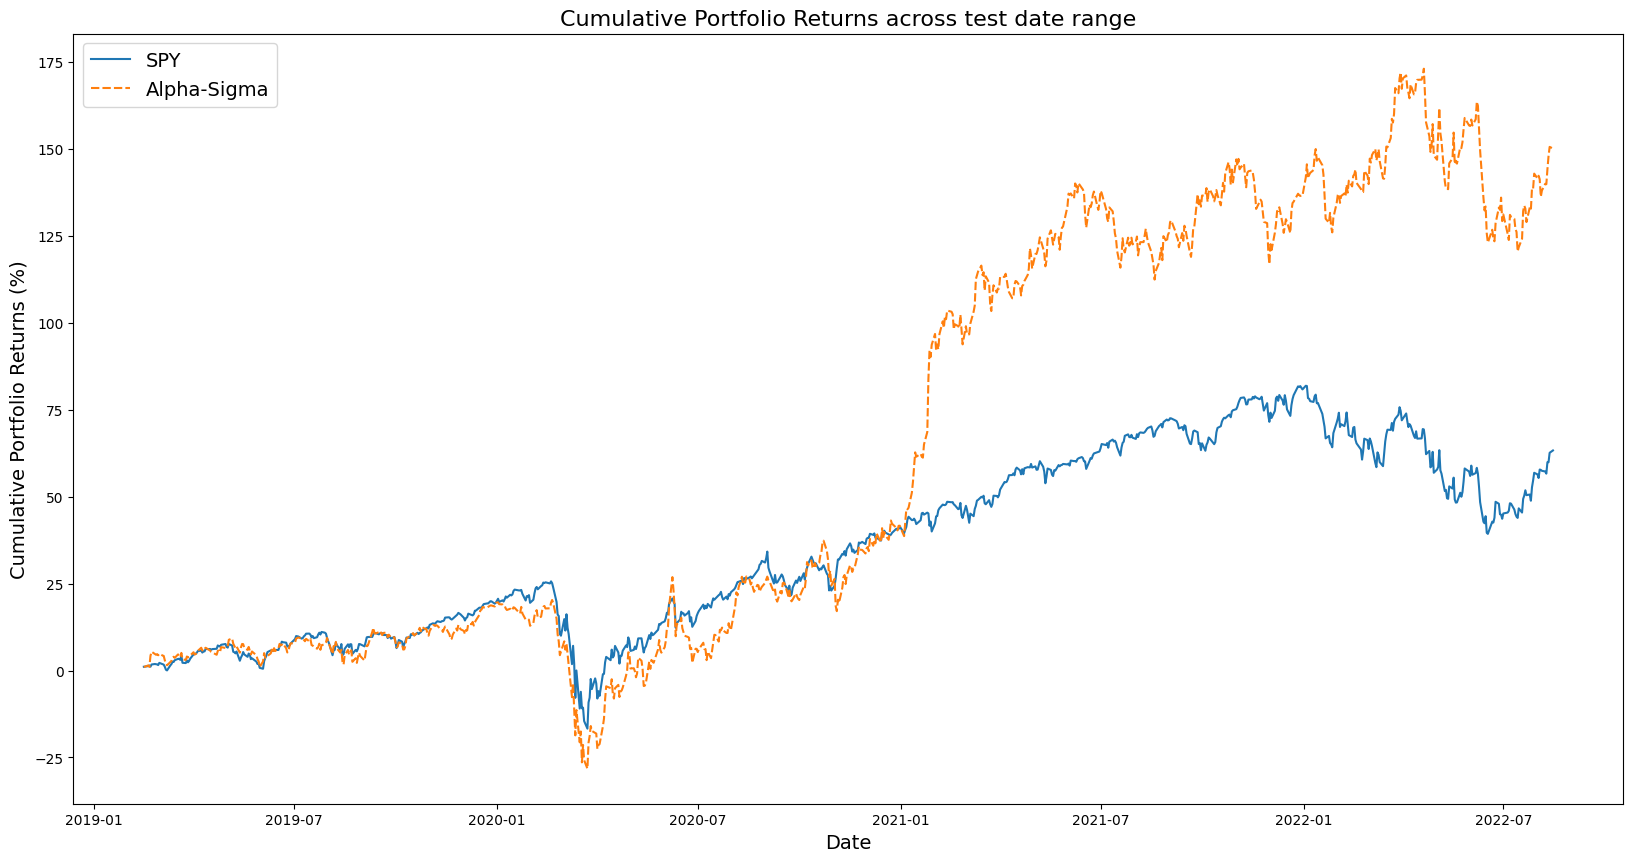

In [851]:
plot_portfolio_ts2("2019-02-15", "2022-08-15")

In [876]:
# 2019 period
get_portfolio_statistics(opt_pf1_rets, "2019-02-15", "2020-02-01","Alpha-Sigma portfolio statistics for 2019")
get_portfolio_statistics(spy_rets, "2019-02-15", "2020-02-01","SPY Portfolio statistics for 2019")

Alpha-Sigma portfolio statistics for 2019
----------------------------------------------------
Annualized returns of portfolio: 13.44%
Annualized volatility of test portfolio: 15.7%
Return-Risk Ratio of test portfolio: 0.856
Parametric Method - 5% VaR: -12.31%

SPY Portfolio statistics for 2019
----------------------------------------------------
Annualized returns of portfolio: 20.36%
Annualized volatility of test portfolio: 11.95%
Return-Risk Ratio of test portfolio: 1.7035
Parametric Method - 5% VaR: 0%



In [877]:
# Only crisis period
get_portfolio_statistics(opt_pf1_rets, "2020-02-20", "2020-04-07","Alpha-Sigma portfolio statistics for Covid crash")
get_portfolio_statistics(spy_rets, "2020-02-20", "2020-04-07","SPY Portfolio statistics for Covid crash")

Alpha-Sigma portfolio statistics for Covid crash
----------------------------------------------------
Annualized returns of portfolio: -91.14%
Annualized volatility of test portfolio: 83.56%
Return-Risk Ratio of test portfolio: -1.0907
Parametric Method - 5% VaR: -228.17%

SPY Portfolio statistics for Covid crash
----------------------------------------------------
Annualized returns of portfolio: -82.86%
Annualized volatility of test portfolio: 77.05%
Return-Risk Ratio of test portfolio: -1.0754
Parametric Method - 5% VaR: -209.22%



In [880]:
# Compare against previous study(2019-01-01 to 2019-12-31)
get_portfolio_statistics(opt_pf1_rets, "2019-01-01", "2019-12-31","Alpha-Sigma statistics for 2019-01-01 to 2019-12-31")
get_portfolio_statistics(spy_rets, "2019-01-01", "2019-12-31","SPY portfolio statistics for 2019-01-01 to 2019-12-31")

Alpha-Sigma statistics for 2019-01-01 to 2019-12-31
----------------------------------------------------
Annualized returns of portfolio: 38.06%
Annualized volatility of test portfolio: 16.66%
Return-Risk Ratio of test portfolio: 2.2849
Parametric Method - 5% VaR: 0%

SPY portfolio statistics for 2019-01-01 to 2019-12-31
----------------------------------------------------
Annualized returns of portfolio: 31.22%
Annualized volatility of test portfolio: 12.51%
Return-Risk Ratio of test portfolio: 2.4957
Parametric Method - 5% VaR: 0%



In [885]:
# Compare against previous study(2013-09-30 to 2017-12-31)
get_portfolio_statistics(opt_pf1_rets, "2013-12-31", "2017-12-31","Portfolio 1 statistics for 2013-12-31 to 2017-12-31")
get_portfolio_statistics(spy_rets, "2013-12-31", "2017-12-31","SPY portfolio statistics for 2013-12-31 to 2017-12-31")

Portfolio 1 statistics for 2013-12-31 to 2017-12-31
----------------------------------------------------
Annualized returns of portfolio: 27.35%
Annualized volatility of test portfolio: 15.47%
Return-Risk Ratio of test portfolio: 1.7676
Parametric Method - 5% VaR: 0%

SPY portfolio statistics for 2013-12-31 to 2017-12-31
----------------------------------------------------
Annualized returns of portfolio: 11.99%
Annualized volatility of test portfolio: 12.04%
Return-Risk Ratio of test portfolio: 0.9963
Parametric Method - 5% VaR: -7.75%

